In [1]:
%matplotlib inline

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
#from mayavi import mlab
import seaborn as sns
from vtk_rw import read_vtk, write_vtk
from plotting import plot_surf_stat_map, crop_img

/home/raid3/huntenburg/workspace/anaconda2/envs/myelinconnect/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
def custom_plot(data, v, f, sulc, thr=1e-50, vmin=None, vmax=None, symmetric=False, figsize=(10,9),  cmap='coolwarm'):
    
    if vmin==None:
        vmin=np.nanmin(data)
    if vmax==None:
        vmax=np.nanmax(data)
        
    
    sns.set_style('white')
    lat=plot_surf_stat_map(v, f, stat_map=data, bg_map=sulc, bg_on_stat=True, darkness=0.4, 
                        elev=180,azim=0, figsize=figsize ,threshold=thr, cmap=cmap, 
                        symmetric_cbar=symmetric, vmin=vmin, vmax=vmax) 

    med=plot_surf_stat_map(v, f, stat_map=data, bg_map=sulc, bg_on_stat=True,darkness=0.4,
            elev=180,azim=180, figsize=figsize, threshold=thr, cmap=cmap, 
                           symmetric_cbar =symmetric, vmin=vmin, vmax=vmax) 

    lat_crop=crop_img(lat)
    med_crop=crop_img(med)

    fig=plt.figure()
    fig.set_size_inches(16, 8)
    ax1 = fig.add_subplot(121)
    plt.imshow(lat_crop)
    ax1.set_axis_off()
    ax2 = fig.add_subplot(122)
    plt.imshow(med_crop)
    ax2.set_axis_off()
    
    return fig

In [4]:
def plot_top(data, column):
    sns.set_style('white')
    fig=plot_surf_stat_map(v, f, stat_map=data[:,column], bg_map=sulc, bg_on_stat=True, darkness=0.5, 
                    elev=270,azim=90, figsize=(10,8),cmap='jet', threshold=1e-50)
    
    fig_crop=crop_img(fig)
    fig=plt.figure()
    fig.set_size_inches(8, 8)
    ax1 = fig.add_subplot(111)
    plt.imshow(fig_crop)
    ax1.set_axis_off()

### Load meshes and masks

In [7]:
rh_mesh_file='/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/inflated/rh_lowres_new_infl50.vtk'
lh_mesh_file='/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/inflated/lh_lowres_new_infl50.vtk'
rh_sulc_file='/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/sulc/rh_sulc.npy'
lh_sulc_file='/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/sulc/lh_sulc.npy'
rh_mask_file='/scr/ilz3/myelinconnect/new_groupavg/masks/rh_fullmask_new.npy'
lh_mask_file='/scr/ilz3/myelinconnect/new_groupavg/masks/lh_fullmask_new.npy'

In [8]:
rh_sulc=np.load(rh_sulc_file)
rh_mask=np.load(rh_mask_file)
rv, rf, rd = read_vtk(rh_mesh_file)
lh_sulc=np.load(lh_sulc_file)
lh_mask=np.load(lh_mask_file)
lv, lf, ld = read_vtk(lh_mesh_file)

### Load and prep data

In [9]:
lh_file = '/scr/ilz3/myelinconnect/new_groupavg/profiles/smooth_3/lh_group_avg_profiles_smooth_3.npy'
rh_file = '/scr/ilz3/myelinconnect/new_groupavg/profiles/smooth_3/rh_group_avg_profiles_smooth_3.npy'
lh_data = np.load(lh_file)
rh_data = np.load(rh_file)
data = np.concatenate((rh_data[:,3:8],lh_data[:,3:8]))

In [10]:
def chebapprox(profiles, degree):
    profiles=np.array(profiles)
    cheb_coeffs=np.zeros((profiles.shape[0],degree+1))
    cheb_polynoms=np.zeros((profiles.shape[0],profiles.shape[1]))
    for c in range(profiles.shape[0]):
        x=np.array(range(profiles.shape[1]))
        y=profiles[c]
        cheb_coeffs[c]=np.polynomial.chebyshev.chebfit(x, y, degree)
        cheb_polynoms[c]=np.polynomial.chebyshev.chebval(x, cheb_coeffs[c])
    return cheb_coeffs, cheb_polynoms

coeffs, _ = chebapprox(data, 5)

/home/raid3/huntenburg/workspace/anaconda2/envs/myelinconnect/lib/python2.7/site-packages/numpy/polynomial/chebyshev.py:1785: RankWarning: The fit may be poorly conditioned
  warnings.warn(msg, pu.RankWarning)


In [11]:
#data=np.load(data_file)
data = coeffs[:,1]

lh_data = data[:lv.shape[0]]
rh_data = data[lv.shape[0]:]

rh_data[rh_mask]=0
lh_data[lh_mask]=0

### Plot

In [36]:
vmin=0
vmax=100

In [37]:
sns.set_style('white')
cropped_images_lh = []
#for column in range(10):
for (elev, azim) in [(180, 0), (180, 180)]:
    plot=plot_surf_stat_map(lv, lf, stat_map=lh_data, bg_map=lh_sulc, bg_on_stat=True, darkness=0.4, 
                        elev=elev,azim=azim, figsize=(10,9) ,threshold=1e-50, cmap='cubehelix',
                        symmetric_cbar=False, vmin=vmin, vmax=vmax)
    cropped_images_lh.append(crop_img(plot))

In [38]:
sns.set_style('white')
cropped_images_rh = []
#for column in range(10):
for (elev, azim) in [(180, 0), (180, 180)]:
    plot=plot_surf_stat_map(rv, rf, stat_map=rh_data, bg_map=rh_sulc, bg_on_stat=True, darkness=0.4, 
                        elev=elev,azim=azim, figsize=(10,7.5) ,threshold=1e-50, cmap='cubehelix',
                        symmetric_cbar=False, vmin=vmin, vmax=vmax)
    cropped_images_rh.append(crop_img(plot))

In [39]:
cropped_img_comb = []
for img in range(int(len(cropped_images_lh)/2)):
    cropped_img_comb.append(cropped_images_lh[2*img])
    cropped_img_comb.append(cropped_images_lh[2*img+1])
    cropped_img_comb.append(cropped_images_rh[2*img])
    cropped_img_comb.append(cropped_images_rh[2*img+1])

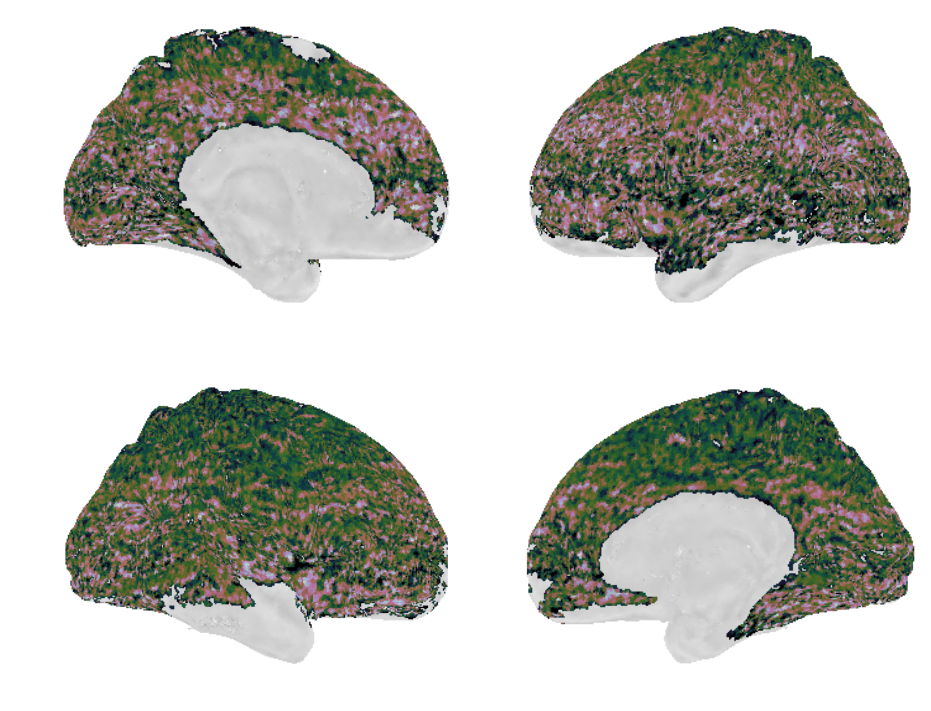

In [40]:
sns.set_style('white')
fig = plt.figure(figsize=(20,50))
for img in range(4):
    ax = fig.add_subplot(10,2,img+1)
    plt.imshow(cropped_img_comb[img])
    ax.set_axis_off
    ax.set_axis_off()
fig.tight_layout()
fig.subplots_adjust(right=0.65)

In [17]:
import pickle
dict_file='/scr/ilz3/myelinconnect/new_groupavg/embed/both_smooth_3_embed_dict.pkl'
fullmask=np.load('/scr/ilz3/myelinconnect/new_groupavg/masks/fullmask_lh_rh_new.npy')
pkl_in = open(dict_file, 'r')
embed_dict = pickle.load(pkl_in)
pkl_in.close()

# normalize vectors
embed_masked = np.zeros((embed_dict['vectors'].shape[0], embed_dict['vectors'].shape[1]-1))
for comp in range(100):
    embed_masked[:,comp]=(embed_dict['vectors'][:,comp+1]/embed_dict['vectors'][:,0])

# unmask the embedding, that has been saved in masked form
idcs=np.arange(0,(lv.shape[0]+rv.shape[0]))
nonmask=np.delete(idcs, fullmask)
embed = np.zeros(((lv.shape[0]+rv.shape[0]),100))
embed[nonmask] = embed_masked

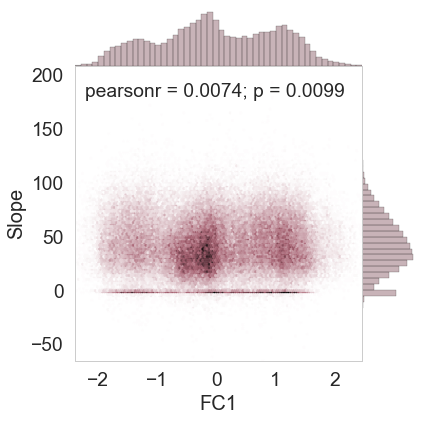

In [24]:
import seaborn as sns
sns.set_style('whitegrid',{'axes.grid': False})
sns.set_context('poster', font_scale=1.2)

#xlim = (-2.5, 2.5)
#ylim = (1600, 2350)
#yticks = [1700, 1900,2100, 2300]
scatter_color = sns.xkcd_rgb['brownish purple']
fig = sns.jointplot(-embed[:,0][data!=0], 
                    data[data!=0],space=0,#ylim=ylim,xlim=xlim,
                    kind="hex", size=6, color=scatter_color)
fig.set_axis_labels('FC1', 'Slope', fontsize=20)
#fig.ax_joint.set_yticks(yticks);

(array([  1.50000000e+01,   3.08000000e+02,   1.90690000e+04,
          4.81870000e+04,   3.76370000e+04,   1.37780000e+04,
          1.73500000e+03,   1.30000000e+02,   2.00000000e+01,
          4.00000000e+00]),
 array([ -63.55560919,  -36.24045732,   -8.92530544,   18.38984644,
          45.70499831,   73.02015019,  100.33530206,  127.65045394,
         154.96560582,  182.28075769,  209.59590957]),
 <a list of 10 Patch objects>)

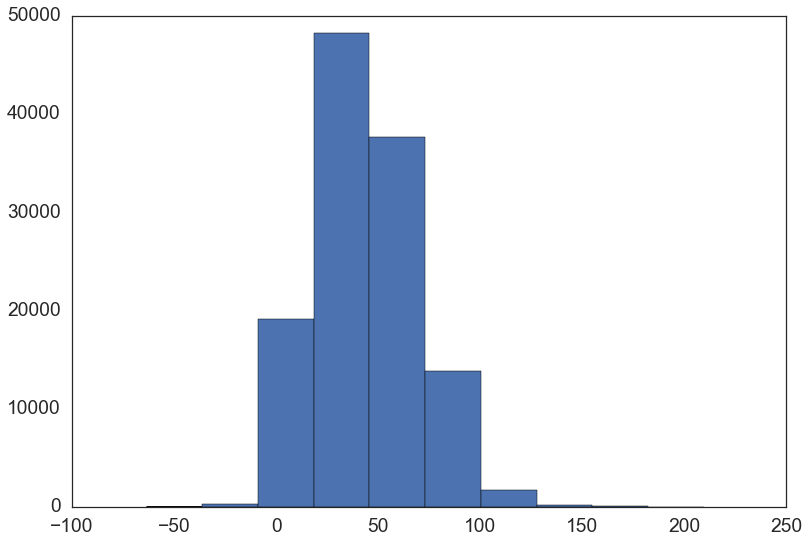

In [35]:
plt.hist(data[data!=0])